In [1]:
import time
import numpy as np
import dxchange
from utils import nor_phase
from ganrec2 import GANphase
import os
from lib import visualize
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import tensorflow_addons as tfa
import tensorflow as tf
import skimage.io as io

In [2]:
energy = 11
z = 7.8880960e-2
pv = 1.04735263e-7
iter_num = 700

# p.lambda = 1.2398/12; %nm
# p.det_pixel = 6.5e3;% nm , eiger
# % p.det_distance = 16.339e9;%nm
# p.det_N_pixel = 2048;% x2167
# p.delta = 1.73788419E-06; % ?? of Be for ?? = 1.848


fname_data = 'data/gan_phase/data_spider.tif'
kwargs = {'energy': energy, 'z': z, 'pv': pv, 'iter_num': iter_num, 'phase_only': False, 'save_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_wpath': 'data/gan_phase/spider_abs_ratio/', 'init_model': False}
data = dxchange.read_tiff(fname_data)
nprj, px,  py = data.shape
data = nor_phase(data)
abs_ratio = 0.01

In [6]:

def measure_reconstruction_quality(img1, img2, experiment_name, csv_file = None, iteration = 0, save = True, epoch_time = 0, total_time = 0):
    assert img1.shape == img2.shape, "img1 and img2 must have the same shape"
    px = img1.shape[0]
    py = img1.shape[1]
    sum_diff = tf.reduce_sum(img1 - img2)/(px*py)
    sum_abs_diff = tf.reduce_sum(tf.abs(img1 - img2))/(px*py)
    sum_squared_diff = tf.reduce_sum(tf.square(img1 - img2))/(px*py)
    psnr = tf.image.psnr(img1, img2, max_val = 1.0)
    ssim = tf.image.ssim(img1, img2, max_val = 1.0)
    nrmse = tf.math.sqrt(tf.reduce_sum(tf.square(img1 - img2))/(px*py))
    mssim = tf.image.ssim_multiscale(img1, img2, max_val = 1.0)
    values = [sum_diff, sum_abs_diff, sum_squared_diff, psnr, ssim, nrmse, mssim]
    values = [v.numpy() for v in values]
    values.insert(0, iteration)
    values.insert(0, experiment_name)
    values.append(epoch_time)
    values.append(total_time)

    import pandas as pd
    df = pd.DataFrame(values, index = ['experiment_name', 'iter', 'sum of pointwise difference', 'sum of absolute value of pointwise difference', 'sum of squared difference', 'PSNR', 'SSIM', 'NRMSE', 'MSSIM', 'epoch_time', 'total_time'])
    # print(df)
    if save:
        if csv_file is not None:
            try:
                df_old = pd.read_csv(csv_file, index_col = 0)
                df = pd.concat([df_old, df], axis = 1)
            except:
                pass
            df.to_csv(csv_file)
        else:
            df.to_csv('metrics.csv')

    return df

In [10]:
abs_ratio_all = np.arange(0.01, 10*0.04, 0.004)
abs_ratio_all = 0.001*np.ones(180)

absorption = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
phase = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
propagated = np.zeros(shape=(abs_ratio_all.shape[0], px, py), dtype=np.float32)
loss = np.zeros(shape=(abs_ratio_all.shape[0], 1), dtype=np.float32)
time_count = np.zeros(shape=(abs_ratio_all.shape[0], 1), dtype=np.float32)

from ganrec_dataloader import measure_reconstruction_quality, tf_reshape, tfback_phase
kwargs['iter_num'] = 300

for i, abs_ratio in enumerate(abs_ratio_all):
    kwargs['save_wpath'] = None
    kwargs['init_model'] = False
    kwargs['recon_monitor'] = False
    idx = i
    gan_phase_object = GANphase(data[idx], **kwargs)
    start = time.time()
    absorption[i], phase[i],propagated[i], loss[i]  = gan_phase_object.recon
    end = time.time()
    time_count[i] = end - start
    matched = tfback_phase( propagated[i], data[idx])
    io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/phase/phase_'+str(idx)+'_'+str(abs_ratio)+'.tif', phase[i])
    io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])
    io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/propagated/propagated_'+str(idx)+'_'+str(abs_ratio)+'.tif', propagated[i])
    df = measure_reconstruction_quality(img1=matched, img2 = tf_reshape(data[idx]), experiment_name = 'spider_hair_'+str(idx)+'_'+str(abs_ratio), csv_file = 'spider_hair_fixed.csv', iteration = kwargs['iter_num'], save = True, epoch_time = time_count[0], total_time = np.sum(time_count))

                                                                 0
experiment_name                                spider_hair_0_0.001
iter                                                           300
sum of pointwise difference                               0.000167
sum of absolute value of pointwise difference            55.933113
sum of squared difference                                17.238338
PSNR                                                   [14.727745]
SSIM                                                   [0.7106953]
NRMSE                                                     4.151908
MSSIM                                                  [0.9449658]
epoch_time                                              [36.47295]
total_time                                                36.47295
                                                                 0
experiment_name                                spider_hair_1_0.001
iter                                                          

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_10_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_10_0.001
iter                                                            300
sum of pointwise difference                                0.000192
sum of absolute value of pointwise difference             74.171539
sum of squared difference                                 24.912384
PSNR                                                    [13.128547]
SSIM                                                     [0.670993]
NRMSE                                                       4.99123
MSSIM                                                   [0.9340353]
epoch_time                                               [36.47295]
total_time                                               403.282959
                                                                  0
experiment_name                                spider_hair_11_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_38_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_38_0.001
iter                                                            300
sum of pointwise difference                                0.000152
sum of absolute value of pointwise difference             63.578461
sum of squared difference                                 22.458668
PSNR                                                    [13.578859]
SSIM                                                   [0.73803866]
NRMSE                                                      4.739058
MSSIM                                                   [0.9536077]
epoch_time                                               [36.47295]
total_time                                              1410.217529


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_39_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_39_0.001
iter                                                            300
sum of pointwise difference                                0.000147
sum of absolute value of pointwise difference             57.642532
sum of squared difference                                 20.256392
PSNR                                                    [14.027079]
SSIM                                                   [0.75645465]
NRMSE                                                       4.50071
MSSIM                                                   [0.9598344]
epoch_time                                               [36.47295]
total_time                                              1445.364746


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_40_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_40_0.001
iter                                                            300
sum of pointwise difference                                0.000158
sum of absolute value of pointwise difference             63.454239
sum of squared difference                                 21.511932
PSNR                                                    [13.765904]
SSIM                                                    [0.7159218]
NRMSE                                                      4.638096
MSSIM                                                  [0.94748443]
epoch_time                                               [36.47295]
total_time                                              1481.604736


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_41_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_41_0.001
iter                                                            300
sum of pointwise difference                                0.000169
sum of absolute value of pointwise difference             56.737015
sum of squared difference                                  19.58449
PSNR                                                    [14.173576]
SSIM                                                    [0.7457731]
NRMSE                                                      4.425436
MSSIM                                                   [0.9545707]
epoch_time                                               [36.47295]
total_time                                              1516.885986
                                                                  0
experiment_name                                spider_hair_42_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_43_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_43_0.001
iter                                                            300
sum of pointwise difference                                0.000158
sum of absolute value of pointwise difference             55.749432
sum of squared difference                                 18.902145
PSNR                                                    [14.327588]
SSIM                                                   [0.76015073]
NRMSE                                                       4.34766
MSSIM                                                   [0.9573419]
epoch_time                                               [36.47295]
total_time                                              1586.061523


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_44_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_44_0.001
iter                                                            300
sum of pointwise difference                                0.000276
sum of absolute value of pointwise difference             58.316261
sum of squared difference                                 19.435999
PSNR                                                    [14.206631]
SSIM                                                    [0.7640401]
NRMSE                                                      4.408628
MSSIM                                                  [0.96203756]
epoch_time                                               [36.47295]
total_time                                              1621.681152


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_45_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_45_0.001
iter                                                            300
sum of pointwise difference                                0.000163
sum of absolute value of pointwise difference             60.688721
sum of squared difference                                 19.888023
PSNR                                                    [14.106783]
SSIM                                                    [0.7363873]
NRMSE                                                      4.459599
MSSIM                                                   [0.9499778]
epoch_time                                               [36.47295]
total_time                                              1657.166138


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_46_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_46_0.001
iter                                                            300
sum of pointwise difference                                0.000188
sum of absolute value of pointwise difference             56.393608
sum of squared difference                                 17.181465
PSNR                                                    [14.742097]
SSIM                                                   [0.77059454]
NRMSE                                                      4.145053
MSSIM                                                  [0.96117383]
epoch_time                                               [36.47295]
total_time                                              1692.078125


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_47_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_47_0.001
iter                                                            300
sum of pointwise difference                                0.000178
sum of absolute value of pointwise difference             65.527695
sum of squared difference                                 19.612375
PSNR                                                   [14.1673975]
SSIM                                                   [0.70902675]
NRMSE                                                      4.428586
MSSIM                                                   [0.9382064]
epoch_time                                               [36.47295]
total_time                                              1728.004517
                                                                  0
experiment_name                                spider_hair_48_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_49_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_49_0.001
iter                                                            300
sum of pointwise difference                                0.000182
sum of absolute value of pointwise difference             52.167007
sum of squared difference                                  17.15011
PSNR                                                   [14.7500305]
SSIM                                                   [0.74591005]
NRMSE                                                      4.141269
MSSIM                                                   [0.9547562]
epoch_time                                               [36.47295]
total_time                                              1801.418335


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_50_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_50_0.001
iter                                                            300
sum of pointwise difference                                0.000146
sum of absolute value of pointwise difference             58.187878
sum of squared difference                                 17.661816
PSNR                                                    [14.622345]
SSIM                                                    [0.7264868]
NRMSE                                                      4.202596
MSSIM                                                   [0.9497975]
epoch_time                                               [36.47295]
total_time                                              1838.381348


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_51_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_51_0.001
iter                                                            300
sum of pointwise difference                                0.000166
sum of absolute value of pointwise difference             58.785675
sum of squared difference                                 18.019409
PSNR                                                    [14.535294]
SSIM                                                    [0.7140427]
NRMSE                                                      4.244927
MSSIM                                                  [0.94688165]
epoch_time                                               [36.47295]
total_time                                              1875.111206


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_52_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_52_0.001
iter                                                            300
sum of pointwise difference                                 0.00018
sum of absolute value of pointwise difference             56.672623
sum of squared difference                                  17.11627
PSNR                                                    [14.758608]
SSIM                                                     [0.732997]
NRMSE                                                      4.137181
MSSIM                                                     [0.95173]
epoch_time                                               [36.47295]
total_time                                               1913.69104
                                                                  0
experiment_name                                spider_hair_53_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_54_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_54_0.001
iter                                                            300
sum of pointwise difference                                0.000145
sum of absolute value of pointwise difference             60.004967
sum of squared difference                                 17.742371
PSNR                                                    [14.602583]
SSIM                                                    [0.7179499]
NRMSE                                                      4.212169
MSSIM                                                  [0.94744676]
epoch_time                                               [36.47295]
total_time                                              1985.082886


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_55_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_55_0.001
iter                                                            300
sum of pointwise difference                                0.000182
sum of absolute value of pointwise difference             56.238625
sum of squared difference                                 17.564392
PSNR                                                    [14.646368]
SSIM                                                    [0.7381207]
NRMSE                                                      4.190989
MSSIM                                                   [0.9530747]
epoch_time                                               [36.47295]
total_time                                              2021.615479
                                                                  0
experiment_name                                spider_hair_56_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_57_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_57_0.001
iter                                                            300
sum of pointwise difference                                0.000212
sum of absolute value of pointwise difference             56.482956
sum of squared difference                                 16.140844
PSNR                                                    [15.013436]
SSIM                                                    [0.7345361]
NRMSE                                                      4.017567
MSSIM                                                  [0.95273453]
epoch_time                                               [36.47295]
total_time                                              2092.486572


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_58_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_58_0.001
iter                                                            300
sum of pointwise difference                                0.000164
sum of absolute value of pointwise difference             53.893917
sum of squared difference                                 15.310895
PSNR                                                    [15.242693]
SSIM                                                    [0.7468001]
NRMSE                                                      3.912914
MSSIM                                                   [0.9566298]
epoch_time                                               [36.47295]
total_time                                              2127.564209
                                                                  0
experiment_name                                spider_hair_59_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_61_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_61_0.001
iter                                                            300
sum of pointwise difference                                0.000165
sum of absolute value of pointwise difference             61.524441
sum of squared difference                                 19.513046
PSNR                                                    [14.189448]
SSIM                                                    [0.6914715]
NRMSE                                                      4.417357
MSSIM                                                   [0.9370709]
epoch_time                                               [36.47295]
total_time                                              2236.966797


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_62_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_62_0.001
iter                                                            300
sum of pointwise difference                                0.000151
sum of absolute value of pointwise difference             54.692268
sum of squared difference                                 17.761532
PSNR                                                    [14.597896]
SSIM                                                    [0.7243331]
NRMSE                                                      4.214443
MSSIM                                                  [0.94690764]
epoch_time                                               [36.47295]
total_time                                              2272.748535
                                                                  0
experiment_name                                spider_hair_63_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_64_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_64_0.001
iter                                                            300
sum of pointwise difference                                0.000186
sum of absolute value of pointwise difference             61.253784
sum of squared difference                                 18.300064
PSNR                                                    [14.468173]
SSIM                                                   [0.71842843]
NRMSE                                                      4.277857
MSSIM                                                  [0.94765395]
epoch_time                                               [36.47295]
total_time                                               2343.33252


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_65_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_65_0.001
iter                                                            300
sum of pointwise difference                                 0.00016
sum of absolute value of pointwise difference             63.800606
sum of squared difference                                 19.647472
PSNR                                                    [14.159633]
SSIM                                                    [0.7154273]
NRMSE                                                      4.432547
MSSIM                                                  [0.95000607]
epoch_time                                               [36.47295]
total_time                                              2378.685791


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_66_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_66_0.001
iter                                                            300
sum of pointwise difference                                 0.00018
sum of absolute value of pointwise difference             58.434803
sum of squared difference                                 17.116119
PSNR                                                    [14.758646]
SSIM                                                    [0.7400159]
NRMSE                                                      4.137163
MSSIM                                                   [0.9568188]
epoch_time                                               [36.47295]
total_time                                              2415.615967


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_67_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_67_0.001
iter                                                            300
sum of pointwise difference                                0.000234
sum of absolute value of pointwise difference             67.134872
sum of squared difference                                 19.888966
PSNR                                                    [14.106578]
SSIM                                                   [0.68674284]
NRMSE                                                      4.459705
MSSIM                                                  [0.94144684]
epoch_time                                               [36.47295]
total_time                                              2451.207031


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_68_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_68_0.001
iter                                                            300
sum of pointwise difference                                 0.00016
sum of absolute value of pointwise difference             52.527531
sum of squared difference                                 17.281069
PSNR                                                    [14.716993]
SSIM                                                   [0.73919296]
NRMSE                                                      4.157051
MSSIM                                                   [0.9540057]
epoch_time                                               [36.47295]
total_time                                              2487.836426


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_69_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_69_0.001
iter                                                            300
sum of pointwise difference                                0.000159
sum of absolute value of pointwise difference             56.286366
sum of squared difference                                 16.266487
PSNR                                                    [14.979761]
SSIM                                                    [0.7442217]
NRMSE                                                      4.033173
MSSIM                                                  [0.95700747]
epoch_time                                               [36.47295]
total_time                                               2523.54248


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_70_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_70_0.001
iter                                                            300
sum of pointwise difference                                0.000166
sum of absolute value of pointwise difference             59.798698
sum of squared difference                                 20.281778
PSNR                                                    [14.021638]
SSIM                                                    [0.7174523]
NRMSE                                                       4.50353
MSSIM                                                  [0.94474655]
epoch_time                                               [36.47295]
total_time                                              2558.924805


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_71_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_71_0.001
iter                                                            300
sum of pointwise difference                                0.000173
sum of absolute value of pointwise difference              59.24052
sum of squared difference                                 18.449562
PSNR                                                    [14.432838]
SSIM                                                    [0.7509288]
NRMSE                                                      4.295295
MSSIM                                                  [0.95793486]
epoch_time                                               [36.47295]
total_time                                               2594.63916
                                                                  0
experiment_name                                spider_hair_72_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_76_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_76_0.001
iter                                                            300
sum of pointwise difference                                0.000179
sum of absolute value of pointwise difference             52.495262
sum of squared difference                                 14.799615
PSNR                                                    [15.390195]
SSIM                                                   [0.76840293]
NRMSE                                                      3.847027
MSSIM                                                   [0.9625512]
epoch_time                                               [36.47295]
total_time                                              2772.274902
                                                                  0
experiment_name                                spider_hair_77_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_80_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_80_0.001
iter                                                            300
sum of pointwise difference                                0.000186
sum of absolute value of pointwise difference             58.599754
sum of squared difference                                 16.431166
PSNR                                                    [14.936016]
SSIM                                                   [0.73779136]
NRMSE                                                      4.053537
MSSIM                                                  [0.95310056]
epoch_time                                               [36.47295]
total_time                                              2915.612061


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_81_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_81_0.001
iter                                                            300
sum of pointwise difference                                0.000178
sum of absolute value of pointwise difference              51.55162
sum of squared difference                                 15.076801
PSNR                                                   [15.3096075]
SSIM                                                   [0.75793815]
NRMSE                                                      3.882886
MSSIM                                                   [0.9578362]
epoch_time                                               [36.47295]
total_time                                              2951.187988


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_82_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_82_0.001
iter                                                            300
sum of pointwise difference                                0.000206
sum of absolute value of pointwise difference             68.427689
sum of squared difference                                  20.18454
PSNR                                                    [14.042511]
SSIM                                                   [0.69647443]
NRMSE                                                      4.492721
MSSIM                                                   [0.9299192]
epoch_time                                               [36.47295]
total_time                                              2986.435059


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_83_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_83_0.001
iter                                                            300
sum of pointwise difference                                0.000169
sum of absolute value of pointwise difference             55.405174
sum of squared difference                                  16.16256
PSNR                                                    [15.007598]
SSIM                                                    [0.7400054]
NRMSE                                                      4.020268
MSSIM                                                   [0.9519683]
epoch_time                                               [36.47295]
total_time                                              3022.297607


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_84_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_84_0.001
iter                                                            300
sum of pointwise difference                                0.000168
sum of absolute value of pointwise difference             53.778214
sum of squared difference                                 16.370813
PSNR                                                    [14.951997]
SSIM                                                   [0.74407786]
NRMSE                                                      4.046086
MSSIM                                                  [0.95238876]
epoch_time                                               [36.47295]
total_time                                              3056.379883


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_85_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_85_0.001
iter                                                            300
sum of pointwise difference                                0.000184
sum of absolute value of pointwise difference             57.892811
sum of squared difference                                 17.243916
PSNR                                                     [14.72634]
SSIM                                                    [0.7307467]
NRMSE                                                      4.152579
MSSIM                                                   [0.9487781]
epoch_time                                               [36.47295]
total_time                                              3093.033691


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_86_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_86_0.001
iter                                                            300
sum of pointwise difference                                0.000186
sum of absolute value of pointwise difference             53.570801
sum of squared difference                                 16.342426
PSNR                                                    [14.959534]
SSIM                                                     [0.747653]
NRMSE                                                      4.042577
MSSIM                                                   [0.9535725]
epoch_time                                               [36.47295]
total_time                                              3129.209473


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_87_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_87_0.001
iter                                                            300
sum of pointwise difference                                0.000174
sum of absolute value of pointwise difference             52.524673
sum of squared difference                                 15.947165
PSNR                                                    [15.065864]
SSIM                                                    [0.7541913]
NRMSE                                                       3.99339
MSSIM                                                  [0.95471555]
epoch_time                                               [36.47295]
total_time                                              3165.439453


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_88_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_88_0.001
iter                                                            300
sum of pointwise difference                                0.000144
sum of absolute value of pointwise difference             60.234398
sum of squared difference                                 18.069511
PSNR                                                    [14.523235]
SSIM                                                   [0.70920014]
NRMSE                                                      4.250824
MSSIM                                                   [0.9420563]
epoch_time                                               [36.47295]
total_time                                              3201.101318
                                                                  0
experiment_name                                spider_hair_89_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_91_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_91_0.001
iter                                                            300
sum of pointwise difference                                0.000189
sum of absolute value of pointwise difference             59.897942
sum of squared difference                                 18.517124
PSNR                                                    [14.416964]
SSIM                                                    [0.7486052]
NRMSE                                                      4.303153
MSSIM                                                  [0.95668864]
epoch_time                                               [36.47295]
total_time                                              3309.922363
                                                                  0
experiment_name                                spider_hair_92_0.001
iter                                            

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_94_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_94_0.001
iter                                                            300
sum of pointwise difference                                0.000154
sum of absolute value of pointwise difference             56.417305
sum of squared difference                                 18.505657
PSNR                                                    [14.419654]
SSIM                                                    [0.7634501]
NRMSE                                                       4.30182
MSSIM                                                  [0.95972633]
epoch_time                                               [36.47295]
total_time                                              3417.141846


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_95_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_95_0.001
iter                                                            300
sum of pointwise difference                                0.000196
sum of absolute value of pointwise difference             59.653862
sum of squared difference                                 20.358015
PSNR                                                    [14.005344]
SSIM                                                   [0.75417155]
NRMSE                                                      4.511986
MSSIM                                                   [0.9613049]
epoch_time                                               [36.47295]
total_time                                              3452.916992


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_96_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_96_0.001
iter                                                            300
sum of pointwise difference                                0.000154
sum of absolute value of pointwise difference             52.486084
sum of squared difference                                 16.557198
PSNR                                                    [14.902831]
SSIM                                                   [0.79316956]
NRMSE                                                      4.069054
MSSIM                                                   [0.9664271]
epoch_time                                               [36.47295]
total_time                                               3489.43042


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_97_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_97_0.001
iter                                                            300
sum of pointwise difference                                0.000189
sum of absolute value of pointwise difference             58.582085
sum of squared difference                                 18.569958
PSNR                                                    [14.404591]
SSIM                                                   [0.76858157]
NRMSE                                                      4.309287
MSSIM                                                  [0.96293294]
epoch_time                                               [36.47295]
total_time                                              3525.844727


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_98_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_98_0.001
iter                                                            300
sum of pointwise difference                                0.000215
sum of absolute value of pointwise difference             58.894798
sum of squared difference                                 17.395248
PSNR                                                    [14.688393]
SSIM                                                    [0.7608646]
NRMSE                                                      4.170761
MSSIM                                                  [0.95880127]
epoch_time                                               [36.47295]
total_time                                              3561.367188


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_99_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                  0
experiment_name                                spider_hair_99_0.001
iter                                                            300
sum of pointwise difference                                0.000252
sum of absolute value of pointwise difference             71.283813
sum of squared difference                                 21.051163
PSNR                                                    [13.859938]
SSIM                                                   [0.68088067]
NRMSE                                                      4.588154
MSSIM                                                   [0.9200274]
epoch_time                                               [36.47295]
total_time                                              3597.080566


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_100_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_100_0.001
iter                                                             300
sum of pointwise difference                                 0.000178
sum of absolute value of pointwise difference              62.766914
sum of squared difference                                   18.75906
PSNR                                                     [14.360588]
SSIM                                                     [0.7511209]
NRMSE                                                       4.331173
MSSIM                                                    [0.9585981]
epoch_time                                                [36.47295]
total_time                                               3633.272461


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_101_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_101_0.001
iter                                                             300
sum of pointwise difference                                 0.000224
sum of absolute value of pointwise difference              55.267548
sum of squared difference                                  16.140656
PSNR                                                     [15.013487]
SSIM                                                    [0.78379387]
NRMSE                                                       4.017543
MSSIM                                                    [0.9659132]
epoch_time                                                [36.47295]
total_time                                               3668.663574


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_102_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_102_0.001
iter                                                             300
sum of pointwise difference                                 0.000159
sum of absolute value of pointwise difference              54.654671
sum of squared difference                                  17.965645
PSNR                                                     [14.548271]
SSIM                                                    [0.74967265]
NRMSE                                                        4.23859
MSSIM                                                   [0.95651495]
epoch_time                                                [36.47295]
total_time                                               3703.745117


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_103_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_103_0.001
iter                                                             300
sum of pointwise difference                                 0.000173
sum of absolute value of pointwise difference              55.335777
sum of squared difference                                   17.47509
PSNR                                                     [14.668505]
SSIM                                                      [0.748547]
NRMSE                                                       4.180322
MSSIM                                                    [0.9557187]
epoch_time                                                [36.47295]
total_time                                               3740.189209


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_104_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_104_0.001
iter                                                             300
sum of pointwise difference                                 0.000236
sum of absolute value of pointwise difference              62.704811
sum of squared difference                                   21.73267
PSNR                                                     [13.721568]
SSIM                                                     [0.7246764]
NRMSE                                                       4.661831
MSSIM                                                    [0.9472867]
epoch_time                                                [36.47295]
total_time                                               3775.310303


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_105_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_105_0.001
iter                                                             300
sum of pointwise difference                                 0.000237
sum of absolute value of pointwise difference              57.168423
sum of squared difference                                  19.344254
PSNR                                                      [14.22718]
SSIM                                                     [0.7583884]
NRMSE                                                        4.39821
MSSIM                                                    [0.9571758]
epoch_time                                                [36.47295]
total_time                                               3811.989502


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_106_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_106_0.001
iter                                                             300
sum of pointwise difference                                 0.000279
sum of absolute value of pointwise difference              60.631973
sum of squared difference                                  21.532263
PSNR                                                     [13.761803]
SSIM                                                    [0.71927565]
NRMSE                                                       4.640287
MSSIM                                                   [0.94727546]
epoch_time                                                [36.47295]
total_time                                               3848.164062
                                                                   0
experiment_name                                spider_hair_107_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_108_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_108_0.001
iter                                                             300
sum of pointwise difference                                  0.00014
sum of absolute value of pointwise difference               54.85936
sum of squared difference                                  22.517733
PSNR                                                     [13.567452]
SSIM                                                    [0.72850263]
NRMSE                                                       4.745285
MSSIM                                                    [0.9455631]
epoch_time                                                [36.47295]
total_time                                               3919.178223


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_109_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_109_0.001
iter                                                             300
sum of pointwise difference                                 0.000197
sum of absolute value of pointwise difference              56.636734
sum of squared difference                                    18.0315
PSNR                                                     [14.532381]
SSIM                                                     [0.7024528]
NRMSE                                                       4.246351
MSSIM                                                   [0.94183075]
epoch_time                                                [36.47295]
total_time                                               3955.427246


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_110_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_110_0.001
iter                                                             300
sum of pointwise difference                                 0.000168
sum of absolute value of pointwise difference              74.860344
sum of squared difference                                  25.265896
PSNR                                                     [13.067352]
SSIM                                                       [0.58725]
NRMSE                                                       5.026519
MSSIM                                                   [0.88940215]
epoch_time                                                [36.47295]
total_time                                                3991.90918


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_111_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_111_0.001
iter                                                             300
sum of pointwise difference                                 0.000155
sum of absolute value of pointwise difference              65.622055
sum of squared difference                                  20.832451
PSNR                                                     [13.905295]
SSIM                                                    [0.65609944]
NRMSE                                                       4.564258
MSSIM                                                     [0.926511]
epoch_time                                                [36.47295]
total_time                                               4028.540039
                                                                   0
experiment_name                                spider_hair_112_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_113_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_113_0.001
iter                                                             300
sum of pointwise difference                                  0.00024
sum of absolute value of pointwise difference              59.064388
sum of squared difference                                  18.313454
PSNR                                                     [14.464996]
SSIM                                                    [0.69434667]
NRMSE                                                       4.279422
MSSIM                                                    [0.9383374]
epoch_time                                                [36.47295]
total_time                                               4099.727539


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_114_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_114_0.001
iter                                                             300
sum of pointwise difference                                 0.000242
sum of absolute value of pointwise difference              62.043285
sum of squared difference                                  18.103149
PSNR                                                     [14.515158]
SSIM                                                    [0.67589873]
NRMSE                                                       4.254779
MSSIM                                                    [0.9366767]
epoch_time                                                [36.47295]
total_time                                               4135.749023


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_115_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_115_0.001
iter                                                             300
sum of pointwise difference                                 0.000163
sum of absolute value of pointwise difference              52.742699
sum of squared difference                                  17.056944
PSNR                                                     [14.773686]
SSIM                                                    [0.71849704]
NRMSE                                                       4.130005
MSSIM                                                   [0.94765216]
epoch_time                                                [36.47295]
total_time                                               4172.534668


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_116_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_116_0.001
iter                                                             300
sum of pointwise difference                                 0.000155
sum of absolute value of pointwise difference              60.354263
sum of squared difference                                  26.487465
PSNR                                                     [12.862295]
SSIM                                                      [0.673793]
NRMSE                                                       5.146597
MSSIM                                                   [0.92834663]
epoch_time                                                [36.47295]
total_time                                               4209.939453


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_117_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_117_0.001
iter                                                             300
sum of pointwise difference                                 0.000191
sum of absolute value of pointwise difference              64.873627
sum of squared difference                                  20.695887
PSNR                                                     [13.933859]
SSIM                                                    [0.65054893]
NRMSE                                                       4.549273
MSSIM                                                    [0.9251273]
epoch_time                                                [36.47295]
total_time                                                4245.78418


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_118_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_118_0.001
iter                                                             300
sum of pointwise difference                                 0.000172
sum of absolute value of pointwise difference              55.520126
sum of squared difference                                  18.656019
PSNR                                                     [14.384509]
SSIM                                                    [0.68464965]
NRMSE                                                       4.319262
MSSIM                                                    [0.9383759]
epoch_time                                                [36.47295]
total_time                                               4280.963867
                                                                   0
experiment_name                                spider_hair_119_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_120_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_120_0.001
iter                                                             300
sum of pointwise difference                                 0.000178
sum of absolute value of pointwise difference              67.531128
sum of squared difference                                  23.058222
PSNR                                                     [13.464441]
SSIM                                                     [0.6589682]
NRMSE                                                       4.801898
MSSIM                                                   [0.92391175]
epoch_time                                                [36.47295]
total_time                                               4352.908203


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_121_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_121_0.001
iter                                                             300
sum of pointwise difference                                 0.000137
sum of absolute value of pointwise difference              58.128399
sum of squared difference                                  23.339615
PSNR                                                     [13.411762]
SSIM                                                     [0.7090991]
NRMSE                                                       4.831109
MSSIM                                                    [0.9359387]
epoch_time                                                [36.47295]
total_time                                               4389.708008
                                                                   0
experiment_name                                spider_hair_122_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_123_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_123_0.001
iter                                                             300
sum of pointwise difference                                  0.00019
sum of absolute value of pointwise difference              62.245018
sum of squared difference                                  23.512453
PSNR                                                     [13.379719]
SSIM                                                     [0.7016564]
NRMSE                                                       4.848964
MSSIM                                                    [0.9381115]
epoch_time                                                [36.47295]
total_time                                               4462.811523


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_124_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_124_0.001
iter                                                             300
sum of pointwise difference                                 0.000164
sum of absolute value of pointwise difference              68.645248
sum of squared difference                                  26.170029
PSNR                                                     [12.914657]
SSIM                                                    [0.70382607]
NRMSE                                                       5.115665
MSSIM                                                   [0.93960094]
epoch_time                                                [36.47295]
total_time                                               4500.020508


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_125_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_125_0.001
iter                                                             300
sum of pointwise difference                                  0.00024
sum of absolute value of pointwise difference              69.348236
sum of squared difference                                  26.770969
PSNR                                                     [12.816058]
SSIM                                                    [0.71175635]
NRMSE                                                       5.174067
MSSIM                                                   [0.93149817]
epoch_time                                                [36.47295]
total_time                                               4537.948242


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_126_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_126_0.001
iter                                                             300
sum of pointwise difference                                 0.000179
sum of absolute value of pointwise difference              64.696259
sum of squared difference                                  27.112419
PSNR                                                     [12.761017]
SSIM                                                     [0.7209724]
NRMSE                                                       5.206959
MSSIM                                                    [0.9370205]
epoch_time                                                [36.47295]
total_time                                               4574.372559


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_127_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_127_0.001
iter                                                             300
sum of pointwise difference                                 0.000259
sum of absolute value of pointwise difference              69.477753
sum of squared difference                                  26.598131
PSNR                                                     [12.844189]
SSIM                                                     [0.6934148]
NRMSE                                                       5.157338
MSSIM                                                    [0.9368823]
epoch_time                                                [36.47295]
total_time                                               4610.742188


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_128_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_128_0.001
iter                                                             300
sum of pointwise difference                                 0.000146
sum of absolute value of pointwise difference              59.424694
sum of squared difference                                  25.443398
PSNR                                                     [13.036947]
SSIM                                                     [0.7228542]
NRMSE                                                       5.044145
MSSIM                                                    [0.9413549]
epoch_time                                                [36.47295]
total_time                                               4648.748047


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_129_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_129_0.001
iter                                                             300
sum of pointwise difference                                 0.000138
sum of absolute value of pointwise difference              63.716557
sum of squared difference                                  27.445995
PSNR                                                     [12.707909]
SSIM                                                     [0.6947634]
NRMSE                                                       5.238893
MSSIM                                                   [0.93376064]
epoch_time                                                [36.47295]
total_time                                               4685.209961


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_130_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_130_0.001
iter                                                             300
sum of pointwise difference                                 0.000146
sum of absolute value of pointwise difference              65.912132
sum of squared difference                                   24.86997
PSNR                                                     [13.135946]
SSIM                                                      [0.666197]
NRMSE                                                        4.98698
MSSIM                                                   [0.92688674]
epoch_time                                                [36.47295]
total_time                                               4722.912598


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_131_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_131_0.001
iter                                                             300
sum of pointwise difference                                 0.000188
sum of absolute value of pointwise difference              66.225319
sum of squared difference                                  22.927015
PSNR                                                     [13.489224]
SSIM                                                     [0.6860815]
NRMSE                                                       4.788216
MSSIM                                                   [0.93591064]
epoch_time                                                [36.47295]
total_time                                               4758.888672
                                                                   0
experiment_name                                spider_hair_132_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_139_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_139_0.001
iter                                                             300
sum of pointwise difference                                 0.000134
sum of absolute value of pointwise difference              61.154602
sum of squared difference                                  23.968861
PSNR                                                     [13.296226]
SSIM                                                     [0.6861289]
NRMSE                                                         4.8958
MSSIM                                                    [0.9374812]
epoch_time                                                [36.47295]
total_time                                               5046.452637


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_140_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_140_0.001
iter                                                             300
sum of pointwise difference                                 0.000133
sum of absolute value of pointwise difference              60.447048
sum of squared difference                                  21.775896
PSNR                                                     [13.712939]
SSIM                                                     [0.6471857]
NRMSE                                                       4.666465
MSSIM                                                   [0.92180985]
epoch_time                                                [36.47295]
total_time                                               5082.998047


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_141_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_141_0.001
iter                                                             300
sum of pointwise difference                                 0.000118
sum of absolute value of pointwise difference              55.861347
sum of squared difference                                  22.047165
PSNR                                                     [13.659172]
SSIM                                                    [0.69557065]
NRMSE                                                       4.695441
MSSIM                                                    [0.9399206]
epoch_time                                                [36.47295]
total_time                                               5117.771484


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_142_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_142_0.001
iter                                                             300
sum of pointwise difference                                 0.000154
sum of absolute value of pointwise difference              64.178818
sum of squared difference                                   24.24048
PSNR                                                     [13.247287]
SSIM                                                    [0.62796724]
NRMSE                                                       4.923462
MSSIM                                                   [0.91321623]
epoch_time                                                [36.47295]
total_time                                               5152.574219


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_143_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_143_0.001
iter                                                             300
sum of pointwise difference                                 0.000144
sum of absolute value of pointwise difference              70.371361
sum of squared difference                                  25.338703
PSNR                                                     [13.054855]
SSIM                                                     [0.6022804]
NRMSE                                                       5.033756
MSSIM                                                    [0.9079367]
epoch_time                                                [36.47295]
total_time                                               5188.739746


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_144_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_144_0.001
iter                                                             300
sum of pointwise difference                                 0.000168
sum of absolute value of pointwise difference              65.378227
sum of squared difference                                  22.349993
PSNR                                                     [13.599925]
SSIM                                                    [0.64419264]
NRMSE                                                       4.727578
MSSIM                                                    [0.9231864]
epoch_time                                                [36.47295]
total_time                                               5225.701172


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_145_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_145_0.001
iter                                                             300
sum of pointwise difference                                 0.000142
sum of absolute value of pointwise difference              59.572861
sum of squared difference                                  21.027851
PSNR                                                      [13.86475]
SSIM                                                     [0.6854503]
NRMSE                                                       4.585613
MSSIM                                                    [0.9323421]
epoch_time                                                [36.47295]
total_time                                                5260.34082


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_146_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_146_0.001
iter                                                             300
sum of pointwise difference                                 0.000184
sum of absolute value of pointwise difference              61.896179
sum of squared difference                                  20.894722
PSNR                                                     [13.892333]
SSIM                                                    [0.67457664]
NRMSE                                                       4.571074
MSSIM                                                    [0.9364446]
epoch_time                                                [36.47295]
total_time                                               5297.307617
                                                                   0
experiment_name                                spider_hair_147_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_149_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_149_0.001
iter                                                             300
sum of pointwise difference                                 0.000119
sum of absolute value of pointwise difference              63.453991
sum of squared difference                                  22.330685
PSNR                                                     [13.603679]
SSIM                                                     [0.6281758]
NRMSE                                                       4.725535
MSSIM                                                   [0.91229653]
epoch_time                                                [36.47295]
total_time                                               5403.940918


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_150_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_150_0.001
iter                                                             300
sum of pointwise difference                                 0.000128
sum of absolute value of pointwise difference              61.865597
sum of squared difference                                  20.461529
PSNR                                                     [13.983317]
SSIM                                                     [0.6612004]
NRMSE                                                       4.523442
MSSIM                                                   [0.92812335]
epoch_time                                                [36.47295]
total_time                                                5440.34082


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_151_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_151_0.001
iter                                                             300
sum of pointwise difference                                 0.000127
sum of absolute value of pointwise difference              66.929001
sum of squared difference                                  22.645947
PSNR                                                     [13.542794]
SSIM                                                     [0.6450085]
NRMSE                                                       4.758776
MSSIM                                                   [0.91986763]
epoch_time                                                [36.47295]
total_time                                               5476.185547


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_152_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_152_0.001
iter                                                             300
sum of pointwise difference                                 0.000176
sum of absolute value of pointwise difference              59.745453
sum of squared difference                                  18.592873
PSNR                                                     [14.399234]
SSIM                                                    [0.69183016]
NRMSE                                                       4.311945
MSSIM                                                     [0.930422]
epoch_time                                                [36.47295]
total_time                                               5512.987305


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_153_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_153_0.001
iter                                                             300
sum of pointwise difference                                 0.000131
sum of absolute value of pointwise difference              59.860245
sum of squared difference                                  18.523411
PSNR                                                     [14.415489]
SSIM                                                    [0.71053153]
NRMSE                                                       4.303883
MSSIM                                                   [0.93891084]
epoch_time                                                [36.47295]
total_time                                               5549.824219


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_154_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_154_0.001
iter                                                             300
sum of pointwise difference                                 0.000155
sum of absolute value of pointwise difference              59.305183
sum of squared difference                                  19.562529
PSNR                                                      [14.17845]
SSIM                                                    [0.69561094]
NRMSE                                                       4.422955
MSSIM                                                   [0.93770796]
epoch_time                                                [36.47295]
total_time                                               5587.335449


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_155_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_155_0.001
iter                                                             300
sum of pointwise difference                                  0.00014
sum of absolute value of pointwise difference              60.746105
sum of squared difference                                  20.584347
PSNR                                                     [13.957328]
SSIM                                                     [0.6935555]
NRMSE                                                       4.536997
MSSIM                                                   [0.93658006]
epoch_time                                                [36.47295]
total_time                                                5623.78418
                                                                   0
experiment_name                                spider_hair_156_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_157_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_157_0.001
iter                                                             300
sum of pointwise difference                                  0.00015
sum of absolute value of pointwise difference              66.151062
sum of squared difference                                  22.271587
PSNR                                                     [13.615188]
SSIM                                                    [0.63103926]
NRMSE                                                       4.719278
MSSIM                                                    [0.9144595]
epoch_time                                                [36.47295]
total_time                                               5696.649902


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_158_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_158_0.001
iter                                                             300
sum of pointwise difference                                 0.000176
sum of absolute value of pointwise difference              64.172089
sum of squared difference                                  20.004936
PSNR                                                     [14.081327]
SSIM                                                     [0.6646324]
NRMSE                                                       4.472688
MSSIM                                                    [0.9240897]
epoch_time                                                [36.47295]
total_time                                                5733.59668


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_159_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_159_0.001
iter                                                             300
sum of pointwise difference                                 0.000117
sum of absolute value of pointwise difference              59.486221
sum of squared difference                                  20.286213
PSNR                                                     [14.020689]
SSIM                                                    [0.67061436]
NRMSE                                                       4.504022
MSSIM                                                   [0.92892766]
epoch_time                                                [36.47295]
total_time                                               5769.720215


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_160_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_160_0.001
iter                                                             300
sum of pointwise difference                                 0.000114
sum of absolute value of pointwise difference              55.074448
sum of squared difference                                   19.03125
PSNR                                                     [14.298026]
SSIM                                                     [0.6930856]
NRMSE                                                       4.362482
MSSIM                                                   [0.93434656]
epoch_time                                                [36.47295]
total_time                                               5806.679199


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_161_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_161_0.001
iter                                                             300
sum of pointwise difference                                 0.000106
sum of absolute value of pointwise difference              61.738674
sum of squared difference                                   22.87537
PSNR                                                     [13.499019]
SSIM                                                     [0.6470287]
NRMSE                                                        4.78282
MSSIM                                                    [0.9182155]
epoch_time                                                [36.47295]
total_time                                               5842.473633


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_162_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_162_0.001
iter                                                             300
sum of pointwise difference                                 0.000168
sum of absolute value of pointwise difference              67.758652
sum of squared difference                                  21.897221
PSNR                                                     [13.688809]
SSIM                                                     [0.6268066]
NRMSE                                                       4.679447
MSSIM                                                    [0.9090906]
epoch_time                                                [36.47295]
total_time                                               5878.730469


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_163_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_163_0.001
iter                                                             300
sum of pointwise difference                                 0.000165
sum of absolute value of pointwise difference              66.600143
sum of squared difference                                  20.893562
PSNR                                                     [13.892574]
SSIM                                                     [0.6301445]
NRMSE                                                       4.570948
MSSIM                                                   [0.91507274]
epoch_time                                                [36.47295]
total_time                                               5915.152344


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_164_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_164_0.001
iter                                                             300
sum of pointwise difference                                 0.000133
sum of absolute value of pointwise difference              55.348991
sum of squared difference                                  18.351448
PSNR                                                     [14.455996]
SSIM                                                      [0.696695]
NRMSE                                                       4.283859
MSSIM                                                    [0.9401598]
epoch_time                                                [36.47295]
total_time                                               5951.453125


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_165_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_165_0.001
iter                                                             300
sum of pointwise difference                                 0.000143
sum of absolute value of pointwise difference              61.141914
sum of squared difference                                  19.967543
PSNR                                                     [14.089453]
SSIM                                                     [0.6670127]
NRMSE                                                       4.468506
MSSIM                                                    [0.9295282]
epoch_time                                                [36.47295]
total_time                                               5989.080566


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_166_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_166_0.001
iter                                                             300
sum of pointwise difference                                 0.000144
sum of absolute value of pointwise difference              56.438141
sum of squared difference                                  19.353746
PSNR                                                     [14.225048]
SSIM                                                    [0.69362545]
NRMSE                                                       4.399289
MSSIM                                                   [0.93962866]
epoch_time                                                [36.47295]
total_time                                               6026.395508


/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_167_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_167_0.001
iter                                                             300
sum of pointwise difference                                 0.000156
sum of absolute value of pointwise difference              68.313896
sum of squared difference                                  22.171413
PSNR                                                     [13.634766]
SSIM                                                    [0.62323236]
NRMSE                                                       4.708653
MSSIM                                                    [0.9111376]
epoch_time                                                [36.47295]
total_time                                               6062.659668
                                                                   0
experiment_name                                spider_hair_168_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_169_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_169_0.001
iter                                                             300
sum of pointwise difference                                  0.00016
sum of absolute value of pointwise difference              58.393555
sum of squared difference                                  20.095732
PSNR                                                     [14.061661]
SSIM                                                    [0.71137273]
NRMSE                                                       4.482826
MSSIM                                                    [0.9449055]
epoch_time                                                [36.47295]
total_time                                               6135.898438
                                                                   0
experiment_name                                spider_hair_170_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_172_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_172_0.001
iter                                                             300
sum of pointwise difference                                 0.000137
sum of absolute value of pointwise difference              63.020645
sum of squared difference                                  19.483217
PSNR                                                     [14.196093]
SSIM                                                    [0.66838014]
NRMSE                                                        4.41398
MSSIM                                                    [0.9321753]
epoch_time                                                [36.47295]
total_time                                               6246.132324
                                                                   0
experiment_name                                spider_hair_173_0.001
iter                              

/tmp/ipykernel_102720/2837361832.py:25: UserWarning: /home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_175_0.001.tif is a low contrast image
  io.imsave('/home/hailudaw/hailudaw/git_folders/ganrec/ganrec/data/gan_phase/spider_for_recon/abs/abs_'+str(idx)+'_'+str(abs_ratio)+'.tif', absorption[i])


                                                                   0
experiment_name                                spider_hair_175_0.001
iter                                                             300
sum of pointwise difference                                 0.000261
sum of absolute value of pointwise difference              56.172939
sum of squared difference                                  16.253145
PSNR                                                     [14.983325]
SSIM                                                     [0.7112895]
NRMSE                                                       4.031519
MSSIM                                                   [0.94893426]
epoch_time                                                [36.47295]
total_time                                               6355.107422
                                                                   0
experiment_name                                spider_hair_176_0.001
iter                              

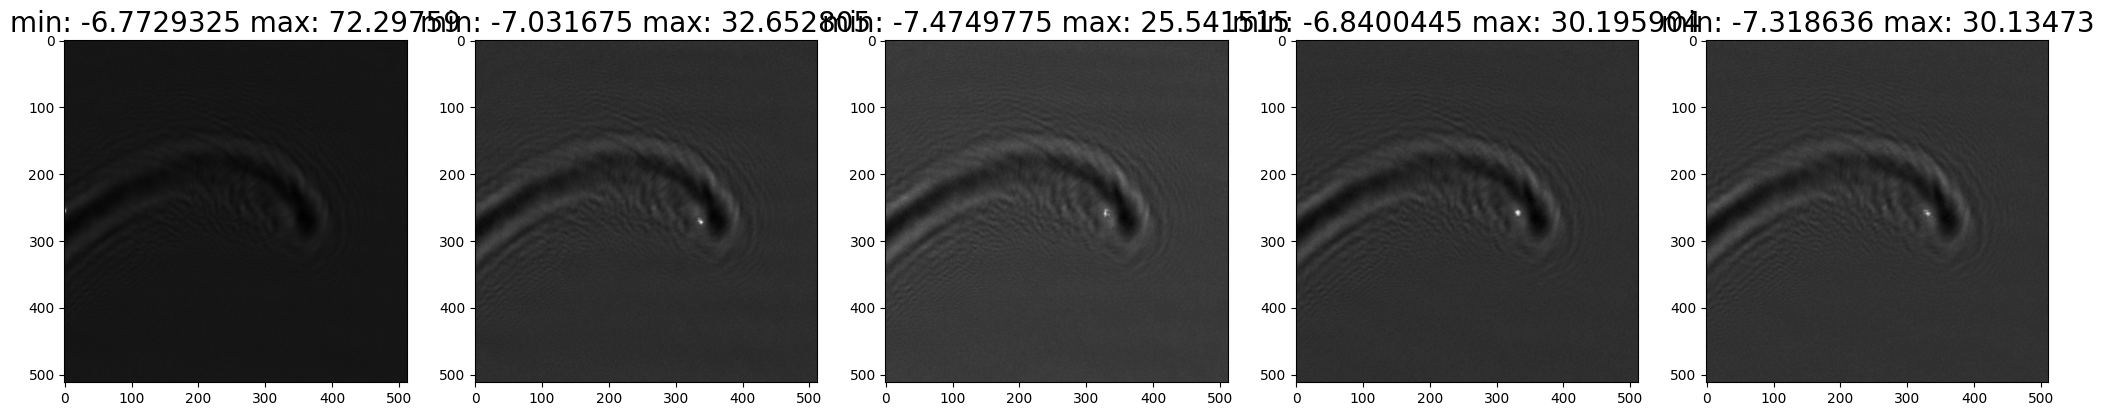

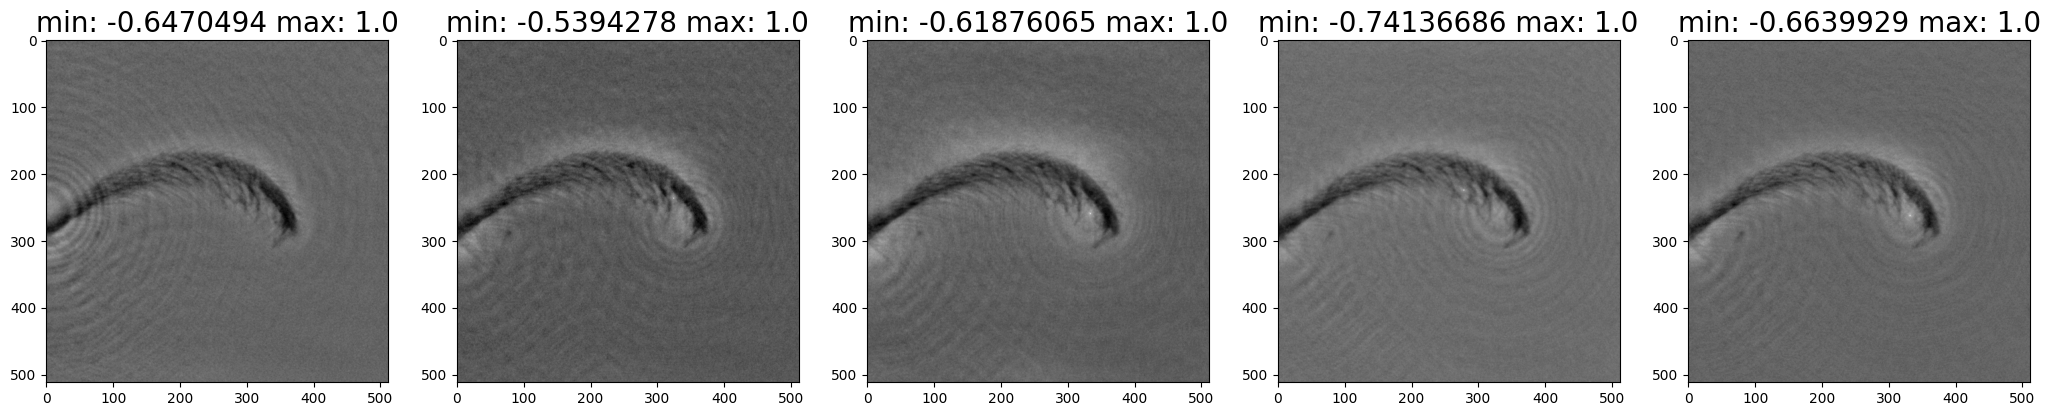

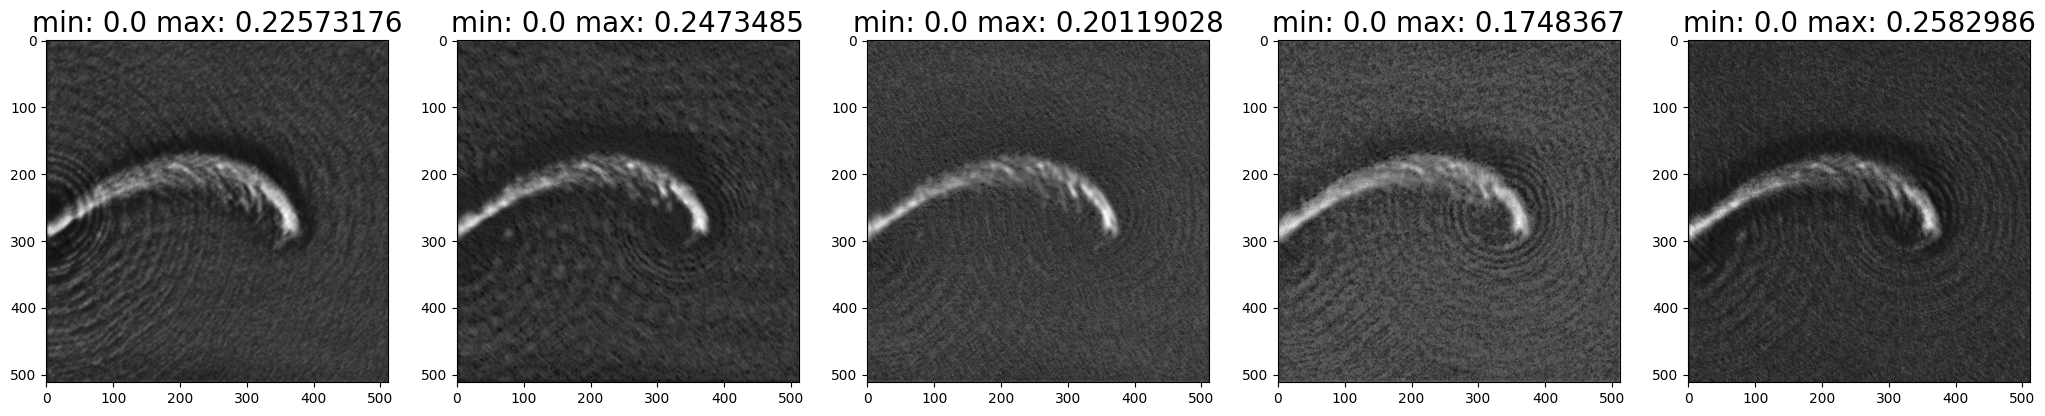

In [5]:
visualize(propagated[0:5])
visualize(phase[0:5])
visualize(absorption[0:5])